In [43]:
import pandas as pd
import numpy as np
import pyhomogeneity as hg
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import skew, t
%config Completer.use_jedi = False #for auto complete code 

In [67]:
obs=pd.read_csv('../data/precp/pp.csv',sep=';')
obs['Fecha'] = pd.to_datetime(obs['Fecha'], dayfirst=True)

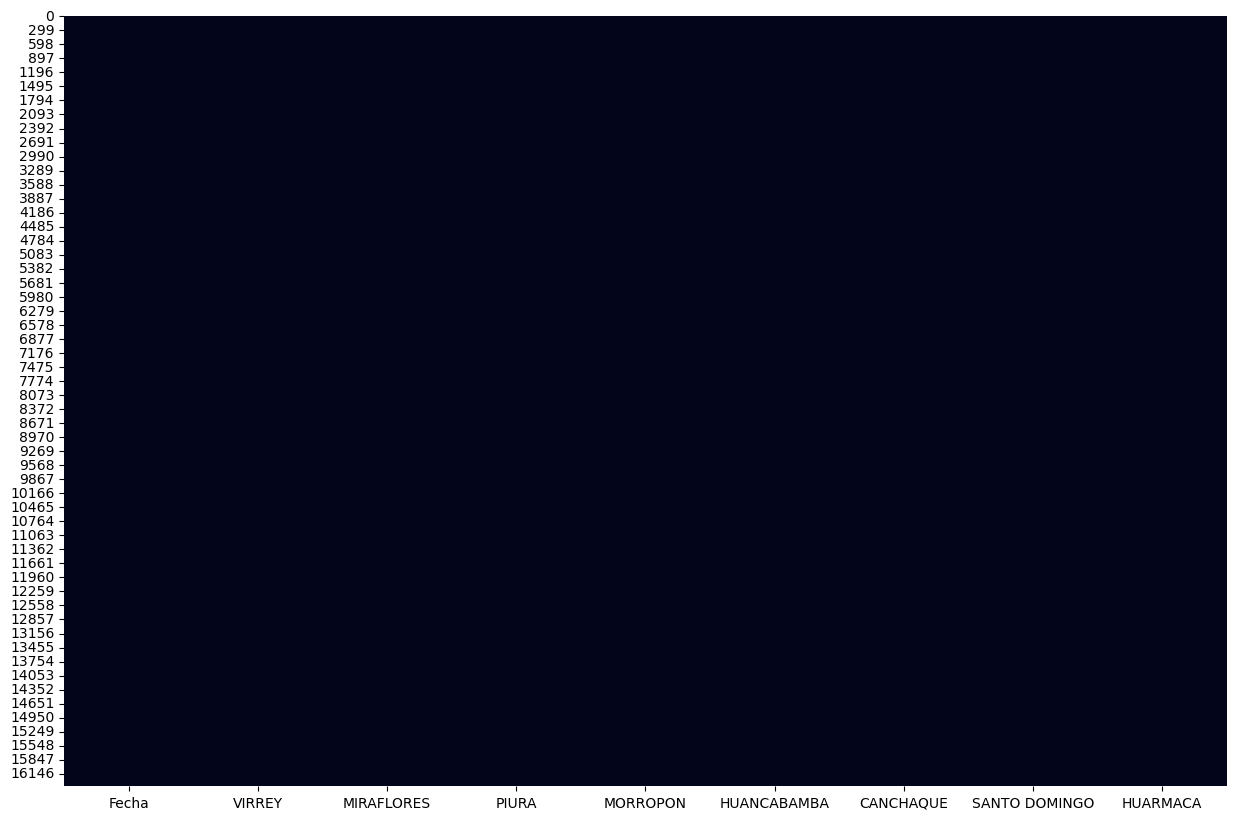

In [3]:
plt.figure(figsize=(15,10))
sns.heatmap(obs.isnull(), cbar=False)
plt.show()

# Remover años El Niño

In [91]:
def remove_years(df, years_to_remove):
    # Convert the first column to datetime if it is not already
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
    
    # Filter out the rows where the year of the date is in the years_to_remove list
    df_filtered = df[~df.iloc[:, 0].dt.year.isin(years_to_remove)]
    
    return df_filtered


# List of years to remove
years_to_remove = [1982,1983, 2017]

# Remove the specified years
df_cleaned = remove_years(obs, years_to_remove)

# Display the result
df_cleaned.head(10)


,Fecha,VIRREY,MIRAFLORES,PIURA,MORROPON,HUANCABAMBA,CANCHAQUE,SANTO DOMINGO,HUARMACA
0,1972-01-01,0.0,0.00,0.0,0.0,6.70,6.8,0.0,3.70
1,1972-01-02,0.0,0.00,0.0,0.0,0.10,1.4,6.4,0.01
2,1972-01-03,0.0,0.40,0.0,0.0,2.60,14.0,18.4,4.10
3,1972-01-04,0.0,1.50,2.0,0.0,0.90,1.4,4.6,2.40
4,1972-01-05,0.0,0.00,0.0,0.0,0.01,1.9,5.6,0.01
5,1972-01-06,0.0,0.00,0.0,0.0,0.00,0.0,0.8,4.10
6,1972-01-07,0.0,0.00,0.0,0.0,2.90,0.5,0.9,0.00
7,1972-01-08,0.0,0.00,0.0,0.0,0.10,0.0,0.7,0.01
8,1972-01-09,0.0,0.00,0.0,0.0,0.40,0.1,2.6,3.10
9,1972-01-10,0.0,0.01,0.0,0.0,1.70,0.8,3.1,1.10


# Doble Masa

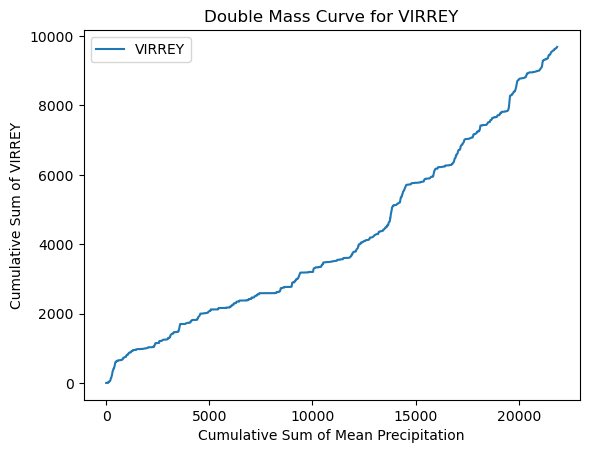

C:\Users\Usuario\AppData\Local\Temp\ipykernel_8588\1487194434.py:32: RuntimeWarning: invalid value encountered in divide
  derivative = np.diff(cumulative_sum) / np.diff(cumulative_mean)


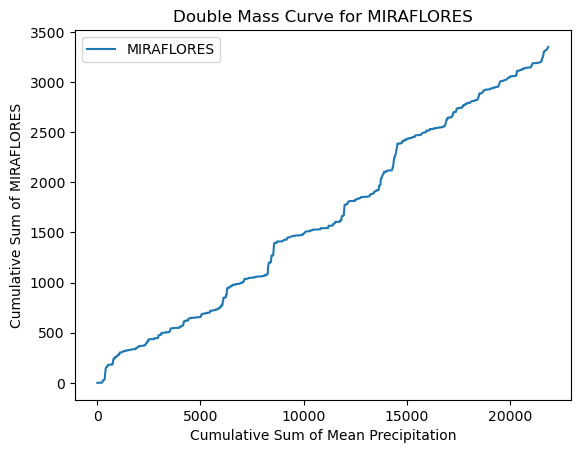

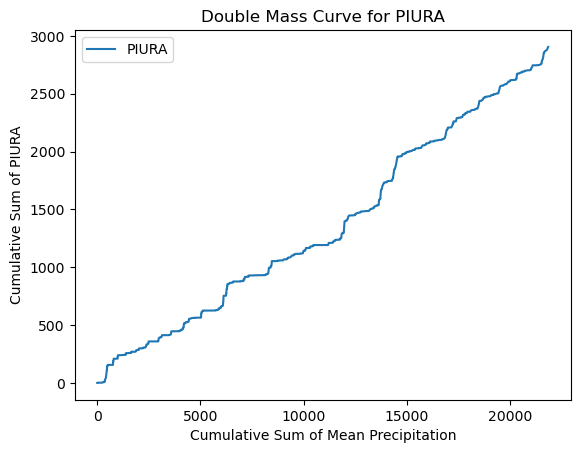

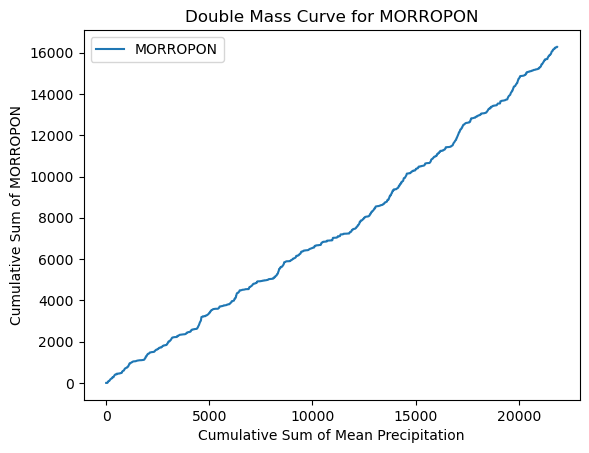

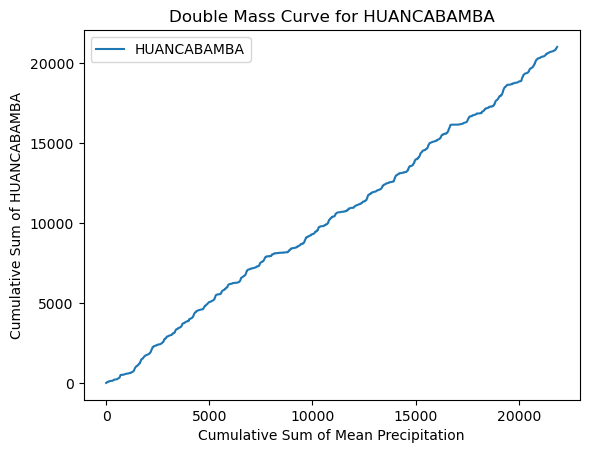

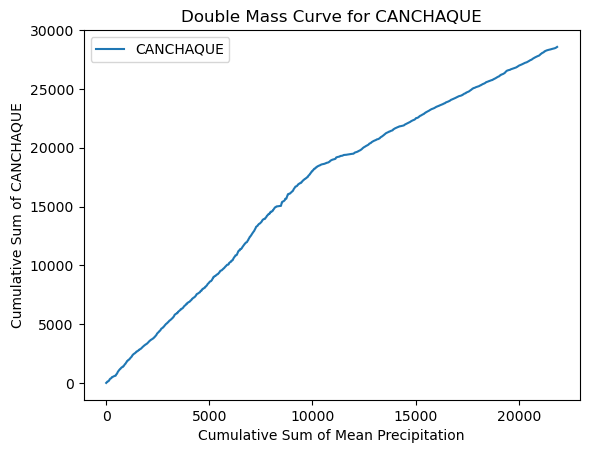

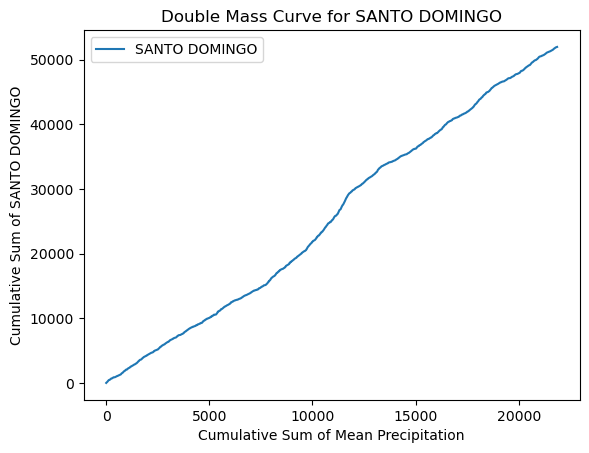

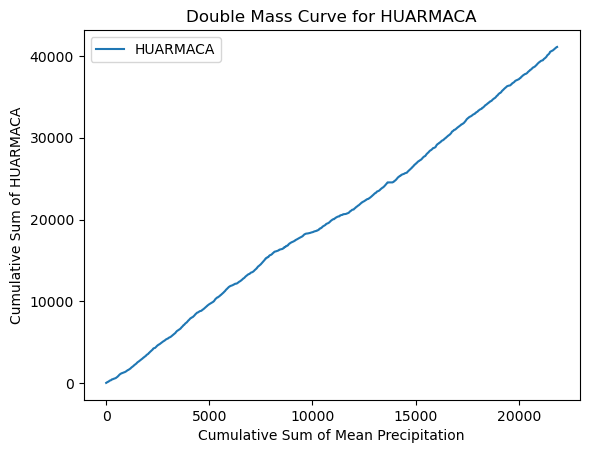

{'VIRREY': [], 'MIRAFLORES': [], 'PIURA': [], 'MORROPON': [], 'HUANCABAMBA': [], 'CANCHAQUE': [], 'SANTO DOMINGO': [], 'HUARMACA': []}


In [19]:
def identify_breaks_dmc(df):
    # Ensure the first column is in datetime format
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
    
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_copy = df.copy()
    
    # Calculate the mean of all gauge stations and add it to the copy DataFrame
    df_copy['Mean'] = df_copy.iloc[:, 1:].mean(axis=1)
    
    # Initialize a dictionary to store results
    breaks_dict = {}
    
    # Calculate cumulative sum of the mean column
    cumulative_mean = df_copy['Mean'].cumsum()
    
    # Iterate over each gauge station, excluding the mean column
    for col in df_copy.columns[1:-1]:
        # Calculate the cumulative sums for the gauge station
        cumulative_sum = df_copy[col].cumsum()
        
        # Plot the double mass curve for visual inspection (optional)
        plt.figure()
        plt.plot(cumulative_mean, cumulative_sum, label=col)
        plt.xlabel('Cumulative Sum of Mean Precipitation')
        plt.ylabel(f'Cumulative Sum of {col}')
        plt.title(f'Double Mass Curve for {col}')
        plt.legend()
        plt.show()
        
        # Identify breaks in the slope using changes in the derivative
        derivative = np.diff(cumulative_sum) / np.diff(cumulative_mean)
        breaks = np.where(np.abs(np.diff(derivative)) > np.mean(np.abs(np.diff(derivative))) + 2 * np.std(np.abs(np.diff(derivative))))[0]
        
        # Store the indices of the breaks in the dictionary
        breaks_dict[col] = list(breaks + 1)  # +1 to account for the shift caused by np.diff
    
    return breaks_dict

# Example usage:
# Assuming df_cleaned is the filtered DataFrame from the previous step
breaks = identify_breaks_dmc(df_cleaned)

# Display the result
print(breaks)

In [92]:
df_cleaned.set_index('Fecha',inplace=True)

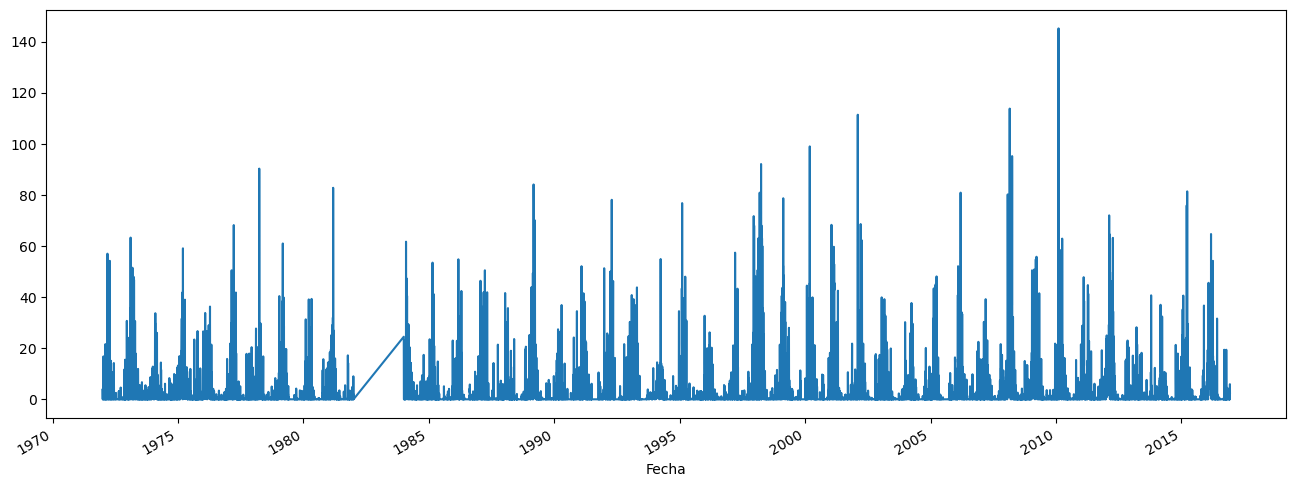

In [93]:
df_cleaned.HUARMACA.plot(figsize=(16,6));

In [98]:
station= 'HUARMACA'
pettitt_res = hg.pettitt_test(df_cleaned[[station]], alpha=0.01)
pettitt_res

Pettitt_Test(h=True, cp='1977-05-16', p=0.0, U=2733220.0, avg=mean(mu1=3.0842333163525213, mu2=2.677505443389213))

In [99]:
snht_res = hg.snht_test(df_cleaned[[station]], sim=100000)
snht_res

SNHT_Test(h=True, cp='1972-04-13', p=0.0, T=51.80559574363307, avg=mean(mu1=8.065192307692307, mu2=2.692788027684704))

In [100]:
buishand_res = hg.buishand_u_test(df_cleaned[[station]])
buishand_res

Buishand_U_Test(h=True, cp='1997-11-22', p=0.0001, U=1.6397566839381283, avg=mean(mu1=2.379562557286893, mu2=3.1661973663982743))

In [71]:
df_month = df_cleaned.groupby(df_cleaned.index.to_period('M')).sum()

In [94]:
station= 'MIRAFLORES'
pettitt_res = hg.pettitt_test(df_month[[station]], alpha=0.01)
pettitt_res

Pettitt_Test(h=False, cp=396, p=0.6415, U=4716.0, avg=mean(mu1=6.4323838383838385, mu2=7.4312938518888885))

In [95]:
snht_res = hg.snht_test(df_month[[station]], sim=10000)
snht_res

SNHT_Test(h=True, cp=3, p=0.0027, T=17.209058567064986, avg=mean(mu1=57.63666666666668, mu2=6.34110526148503))

In [96]:
buishand_res = hg.buishand_u_test(df_month[[station]])
buishand_res

Buishand_U_Test(h=False, cp=217, p=0.6317, U=0.09064110258151328, avg=mean(mu1=4.935990783410138, mu2=7.939699428585366))

In [97]:
df_month

,VIRREY,MIRAFLORES,PIURA,MORROPON,HUANCABAMBA,CANCHAQUE,SANTO DOMINGO,HUARMACA,Weight,Weighted_Precipitation
Fecha,,,,,,,,,,
1972-01,0.030000,1.910000,2.000000,1.000000,55.120000,70.530000,110.700000,75.180000,3.1,35.152700
1972-02,29.650000,0.200000,0.000000,95.000000,28.100000,94.620000,282.610000,105.060000,2.9,70.195400
1972-03,603.510000,170.800000,154.000000,351.400000,150.420000,603.700000,637.300000,512.020000,3.1,350.487500
1972-04,20.260000,8.600000,0.000000,4.000000,73.120000,287.500000,136.020000,213.560000,3.0,82.066600
1972-05,0.020000,0.710000,0.000000,11.400000,27.410000,48.100000,58.830000,86.730000,3.1,25.993000
...,...,...,...,...,...,...,...,...,...,...
2016-08,0.000000,1.098000,1.098000,0.000000,6.782000,1.851000,1.100000,0.000000,3.1,1.653190
2016-09,11.377000,5.611000,5.611000,1.106000,10.976000,12.003000,11.798000,21.205000,3.0,9.095570
2016-10,7.378000,4.296000,4.296000,0.700000,40.289000,10.737000,12.106000,27.448000,3.1,12.138500
